In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [78]:
original_test_df = pd.read_csv('./Data/test.csv')
original_train_df = pd.read_csv('./Data/train.csv')

In [79]:
def titanic_data_shaping(df):
    # Sex
    df.Sex = df.Sex.map({'female':0,'male':1})

    # Title
    # Regexp tips :
    # () : matches the group within
    # + : matches the expression to its left one or more times
    # \. search for '.' otherwise . alone is a special character
    # '([A-Za-z]+)\.' search for matches to groups of letters ending with a .

    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')
    least_occuring_titles = ['Dr','Rev','Major','Col','Capt','Jonkheer','Don','Sir']
    df['Feature_Title']=df['Title']
    df['Feature_Title']=df['Feature_Title'].replace(['Ms','Mme','Countess'],'Mrs')
    df['Feature_Title']=df['Feature_Title'].replace(['Lady','Mlle'],'Miss')
    df['Feature_Title']=df['Feature_Title'].replace(least_occuring_titles,'Rare')
    df.Feature_Title.value_counts()
    df.Feature_Title = df.Feature_Title.map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Rare':4},na_action='ignore')

    df["Ticket Number"] = [int(df.iloc[i]["Ticket"].split()[-1]) if df.iloc[i]["Ticket"].split()[-1] != 'LINE' else 0 for i in range(len(df)) ]

    # Training Data shuffle
    df = df.reindex(np.random.permutation(df.index))

    # Age
    df_age = df['Age'].fillna(df['Age'].median())
    df['Feature_Age'] = (df_age - df_age.mean()) / (df_age.max() - df_age.min())

    return df

train_df = titanic_data_shaping(original_train_df)
test_df = titanic_data_shaping(original_test_df)


In [80]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Feature_Title,Ticket Number,Feature_Age
32,33,1,3,"Glynn, Miss. Mary Agatha",0,NaN,0,0,335677,7.7500,NaN,Q,Miss,1,335677,-0.017110
528,529,0,3,"Salonen, Mr. Johan Werner",1,39.0,0,0,3101296,7.9250,NaN,S,Mr,0,3101296,0.121116
315,316,1,3,"Nilsson, Miss. Helmina Josefina",0,26.0,0,0,347470,7.8542,NaN,S,Miss,1,347470,-0.042242
859,860,0,3,"Razi, Mr. Raihed",1,NaN,0,0,2629,7.2292,NaN,C,Mr,0,2629,-0.017110
861,862,0,2,"Giles, Mr. Frederick Edward",1,21.0,1,0,28134,11.5000,NaN,S,Mr,0,28134,-0.105071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",0,23.0,0,0,SC/AH Basle 541,13.7917,D,C,Mrs,2,541,-0.079939
175,176,0,3,"Klasen, Mr. Klas Albin",1,18.0,1,1,350404,7.8542,NaN,S,Mr,0,350404,-0.142769
846,847,0,3,"Sage, Mr. Douglas Bullen",1,NaN,8,2,CA. 2343,69.5500,NaN,S,Mr,0,2343,-0.017110
877,878,0,3,"Petroff, Mr. Nedelio",1,19.0,0,0,349212,7.8958,NaN,S,Mr,0,349212,-0.130203


In [81]:
def build_model(model_learning_rate,feature_size,classification_threshold):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=1,input_shape=(feature_size,),activation=tf.keras.activations.sigmoid))

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=model_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=classification_threshold),
            tf.keras.metrics.Precision(name='precision',thresholds=classification_threshold),
            tf.keras.metrics.Recall(name='recall',thresholds=classification_threshold)]
        )

    return model

In [82]:
def train_model(model, feature, label, epochs, validation_split):
    history = model.fit(
        x=feature,
        y=label,
        batch_size=None,
        epochs=epochs,
        shuffle=True,
        validation_split=validation_split)

    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs = history.epoch

    hist = pd.DataFrame(history.history)


    return trained_weight, trained_bias, epochs, hist



In [83]:
def plot_results(epochs,metric,hist):
    #Loss curve
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.plot(epochs, hist[metric], label=metric,c='r')
    plt.plot(epochs, hist['val_'+metric], label='validation '+metric,c='b')
    plt.legend()
    plt.ylim([0.2, 1.0])
    plt.show()



In [84]:
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Feature_Title,Ticket Number,Feature_Age
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.723906,2.969891e+05,3.488916e-17
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,1.020069,6.564383e+05,1.636051e-01
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-3.636791e-01
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,1.431250e+04,-9.250543e-02
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.120580e+05,-1.710961e-02
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,3.470820e+05,7.085219e-02
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,3.101317e+06,6.363209e-01


In [85]:
# Hyperparameters.
learning_rate = 0.008
epochs = 50
batch_size = 22
validation_split = 0.2
classification_threshold = 0.5

my_feature = ["Pclass","Feature_Title","Sex"]
my_label="Survived" 

# Discard any pre-existing version of the model.
my_model = None

# Save previous results
#prev_hist = hist
#prev_epochs = epochs

# Build and Train
my_model = build_model(learning_rate,len(my_feature),classification_threshold)
weight, bias, epochs, hist = train_model(my_model, train_df[my_feature], train_df[my_label], epochs, validation_split)

Epoch 1/50
23/23 [==============================] - 1s 33ms/step - loss: 1.0801 - accuracy: 0.2219 - precision: 0.1550 - recall: 0.2230 - val_loss: 0.9634 - val_accuracy: 0.5475 - val_precision: 0.3023 - val_recall: 0.2031
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.9603 - accuracy: 0.5295 - precision: 0.2522 - recall: 0.1043 - val_loss: 0.8725 - val_accuracy: 0.5475 - val_precision: 0.3023 - val_recall: 0.2031
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.8676 - accuracy: 0.5562 - precision: 0.2979 - recall: 0.1007 - val_loss: 0.7873 - val_accuracy: 0.6425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.7860 - accuracy: 0.6067 - precision: 0.3333 - recall: 0.0072 - val_loss: 0.7147 - val_accuracy: 0.6425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.60

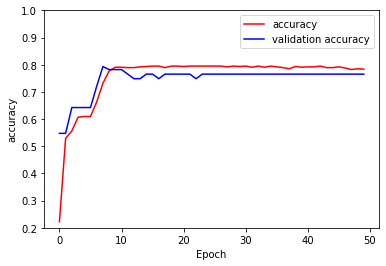

In [86]:
plot_results(epochs,'accuracy',hist)

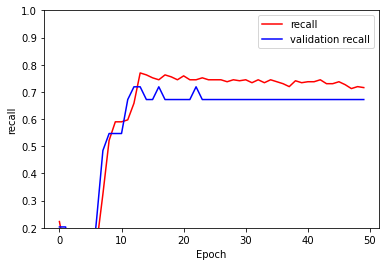

In [87]:
plot_results(epochs,'recall',hist)

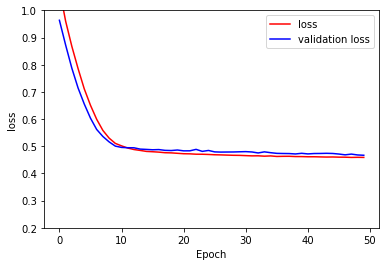

In [88]:
plot_results(epochs,'loss',hist)

In [89]:
weight, bias

(array([[-0.6467136 ],
        [ 0.46905696],
        [-2.0007772 ]], dtype=float32),
 array([1.6932913], dtype=float32))

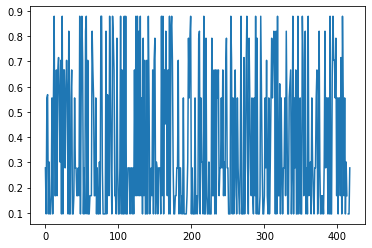

In [90]:
# Predict
plt.plot(my_model.predict(test_df[my_feature]))

In [91]:
prediction_tensor = tf.keras.activations.sigmoid(np.dot(test_df[my_feature],weight)+bias)

In [92]:
# Prepare sumbmission file
prediction_df = test_df[["PassengerId"]].copy()

In [93]:
list_of_list = (prediction_tensor.numpy() >= classification_threshold).astype(int).tolist()
survived_list = [item for elem in list_of_list for item in elem]
prediction_df = prediction_df.assign(Survived=survived_list)

In [94]:
prediction_df.to_csv('./deeplearning_submission.csv',index=False,header=True)

In [95]:
example_csv = pd.read_csv('./Data/gender_submission.csv')
prediction_csv = pd.read_csv('./deeplearning_submission.csv')

In [96]:
example_csv.Survived.value_counts(), prediction_csv.Survived.value_counts(), 

(0    266
 1    152
 Name: Survived, dtype: int64,
 0    260
 1    158
 Name: Survived, dtype: int64)